In [1]:
import copy as cp
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pyfits

from starlet import Starlet_Filter2D, Starlet_Backward2D, Starlet_Forward2D, Apply_H1


## Setup filter

[ 0.0625  0.25    0.375   0.25    0.0625]


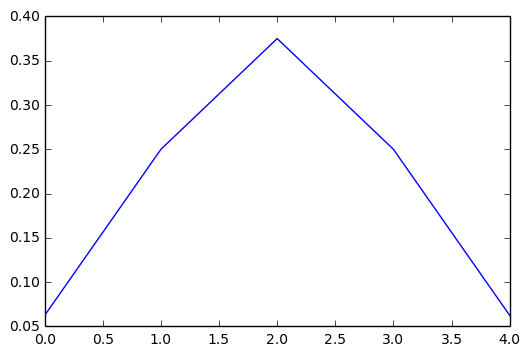

In [2]:
h1d = np.array([1/16, 1/4, 3/8, 1/4, 1/16])
print(h1d)
plt.plot(h1d)
plt.show()

# Galaxy NCG 2997

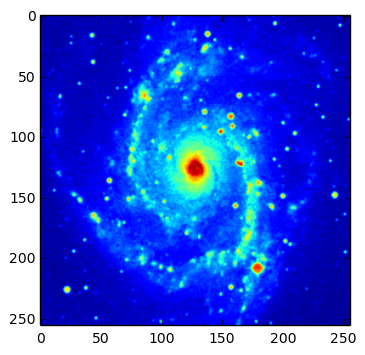

In [3]:
initialIm = pyfits.open('ngc2997.fits')[0].data
plt.imshow(initialIm)
plt.show()

As the filter is linearly separable, 
we can operate the convolution first on the rows and then on the columns to obtain the final convoluted image.

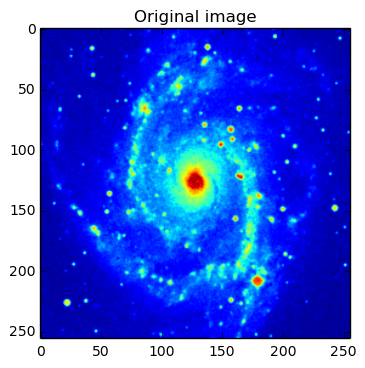

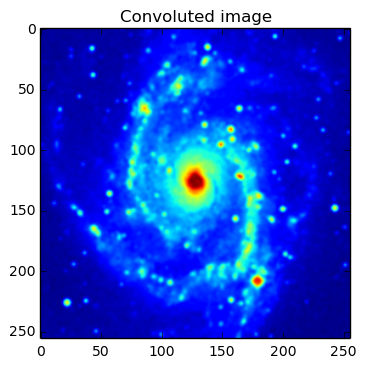

In [4]:
def convolve1D(values, filterName):
    return np.sum(values*filterName[::-1])

def convolve2DCol(initImage, filterName):
    # Convolve with mirror padding
    filterSize = filterName.shape[0]
    filterHalfSize = int((filterSize - 1)/2)
    imageRowNb = initImage.shape[0]
    imageColNb = initImage.shape[1]
    newImage = np.zeros([imageRowNb, imageColNb])
    imageWithPadding = np.zeros([imageRowNb,imageColNb + 2*(filterSize - 1)])
    imageWithPadding[0:imageRowNb, filterSize - 1 : imageColNb + filterSize - 1 ] = initImage
    imageWithPadding[0:imageRowNb, 0:filterSize - 1] = initImage[0:imageRowNb,filterSize - 2: :-1]
    imageWithPadding[0:imageRowNb, imageColNb + filterSize - 1:] = initImage[0:imageRowNb,: -filterSize :-1]
    for rowIndex in range(imageRowNb):
        for colIndex in range(imageColNb):
            newImage[rowIndex,colIndex] = convolve1D(imageWithPadding[rowIndex, colIndex   + filterSize - 1 - filterHalfSize : colIndex + filterSize  + filterHalfSize], filterName)        
    return newImage
 
def convolve2DRow(initImage, filterName):
    # Convolve with mirror padding
    filterSize = filterName.shape[0]
    filterHalfSize = int((filterSize - 1)/2)
    imageRowNb = initImage.shape[0]
    imageColNb = initImage.shape[1]
    newImage = np.zeros([imageRowNb, imageColNb])
    imageWithPadding = np.zeros([imageRowNb + 2*(filterSize - 1),imageColNb])
    imageWithPadding[filterSize - 1 :  imageRowNb + filterSize - 1 , 0 :imageColNb] = initImage
    imageWithPadding[0:filterSize - 1, 0:imageColNb] = initImage[filterSize - 2: :-1, 0:imageColNb]
    imageWithPadding[ imageColNb + filterSize - 1 : ,0:imageColNb] = initImage[: -filterSize :-1, 0:imageColNb]
    for rowIndex in range(imageRowNb):
        for colIndex in range(imageColNb):
            newImage[rowIndex,colIndex] = convolve1D(imageWithPadding[rowIndex + filterSize - 1 - filterHalfSize: rowIndex + filterSize + filterHalfSize , colIndex], filterName)        
    return newImage


def convolve2D(initialIm, filter):
    return convolve2DRow(convolve2DCol(initialIm,filter),filter) 

newIm = convolve2D(initialIm, h1d)
plt.imshow(initialIm)
plt.title('Original image')
plt.show()
plt.imshow(newIm)
plt.title('Convoluted image')
plt.show()

## Starlet transform

We can now operate the starlet transform by iteratively applying the following steps :

- convolve the current image with the given scale filter 

- subtract the convolved image from the current image, which gives us the starlet coefficients

- make the convolved image the current image

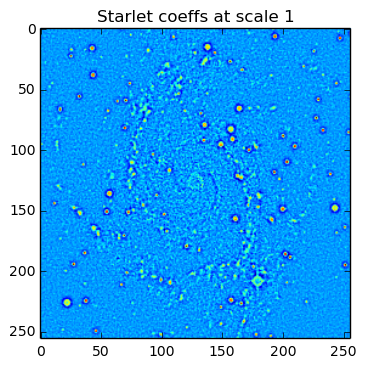

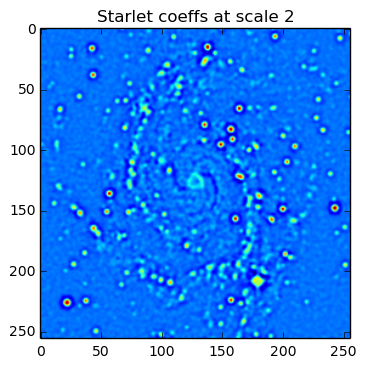

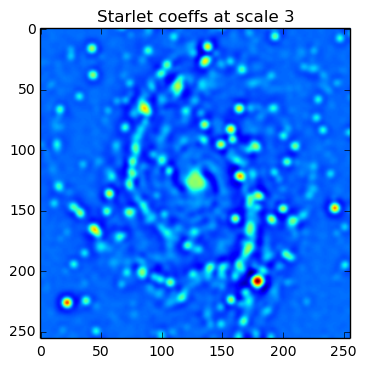

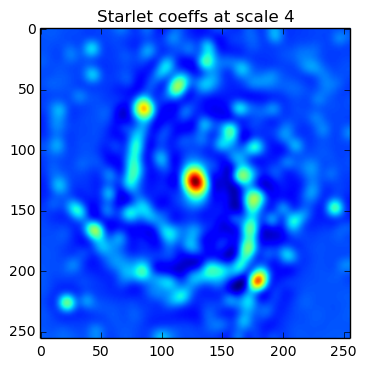

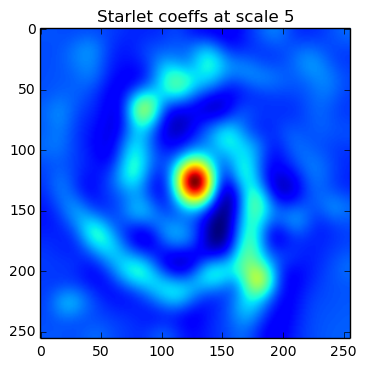

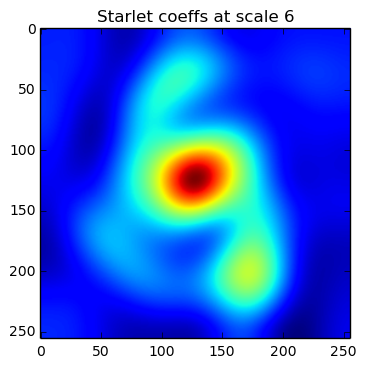

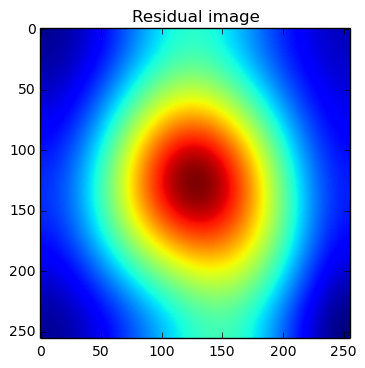

In [5]:
def enlargeFilter(filterName, twoPow):
    if twoPow > 0:
        filterName = np.hstack([[value] + [0]*(pow(2,twoPow) - 1) for value in filterName])[0:-pow(2,twoPow) + 1]
    return filterName

def starletTransform(initialImage, filterName, twoPow, cmap='jet'):
    coeffs = np.zeros([twoPow, initialImage.shape[0], initialImage.shape[1]])
    meanWav = np.zeros(twoPow)
    currentImage = cp.copy(initialImage)
    for iteration in range(twoPow):
        resizedFilter = enlargeFilter(filterName, iteration - 1)
        newIm = convolve2D(currentImage, enlargeFilter(filterName, iteration))
        coeffs[iteration] = currentImage - newIm
        meanWav[iteration] = np.mean(currentImage - newIm) 
        currentImage = newIm
        plt.imshow(coeffs[iteration], cmap)
        plt.title('Starlet coeffs at scale {scale}'.format(scale=iteration + 1))
        plt.show()
    return coeffs, currentImage, meanWav
      
def reconstructImage(coeffs, finalImage):
    waveletNb = coeffs.shape[0]
    reconstructedImage = finalImage
    for idx in range(waveletNb):
        reconstructedImage = reconstructedImage + coeffs[idx]
    return reconstructedImage


starCoeffs, lastIm, meanWav = starletTransform(initialIm, h1d, 6)
plt.imshow(lastIm)
plt.title('Residual image')
plt.show()


## Observations of Starlet coefficients

We see that each wavelet scale captures the details at a given scale.

At the first stage we capture very fine details which are only several pixels wide.

At the last stage (6th in our case), we observe the global large variations over the image, which gives us information about the galaxie's global outline.


In [6]:
print('means of wavelet coefficients at each scale : {means}'.format(means=meanWav))

means of wavelet coefficients at each scale : [ 0.  0.  0.  0.  0.  0.]


As expected, at each scale, the mean of the wavelet coefficients is zero.


## Reconstruction

We can reconstruct the image by summing the residual image and all the wavelet coefficients.

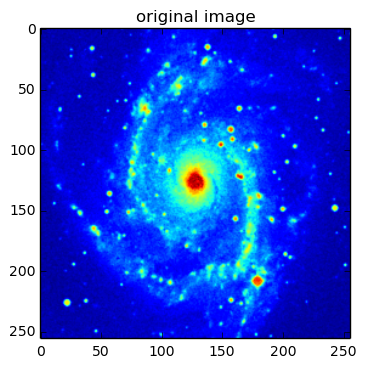

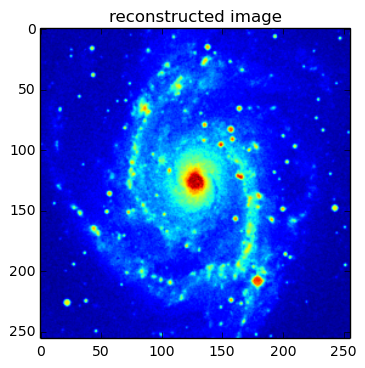

In [7]:
starIm = reconstructImage(starCoeffs, lastIm)

# Display original image
plt.imshow(starIm)
plt.title('original image')
plt.show()

# Display reconstructed image
plt.imshow(initialIm)
plt.title('reconstructed image')
plt.show()

In [8]:
# Compute the pixel differences between the original and reconstructed images
print('Sum of pixel differences : {sum}'. format(sum=np.sum(starIm - initialIm)))

Sum of pixel differences : 3.126388037344441e-12


We can see both numerically and visually that the original image and the reconstructed image after the starlet transform are identical

# Kronecker 

We will now analyze the wavelet transform of a basic Kronecker signal which has a value of 1 when x==y and 0 otherwise.

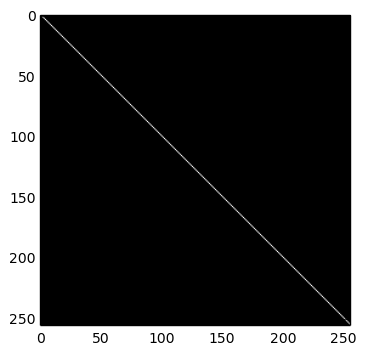

In [9]:
kronIm = np.eye(256, 256)
plt.imshow(kronIm, cmap='gray')
plt.show()

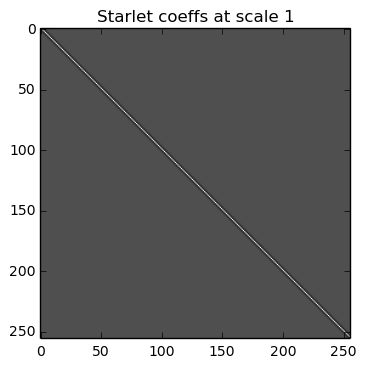

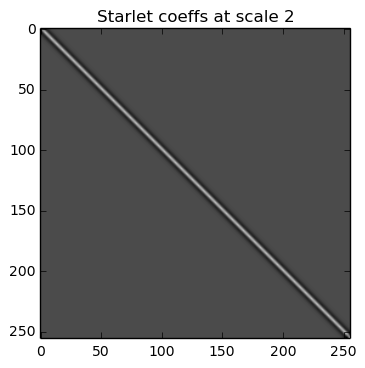

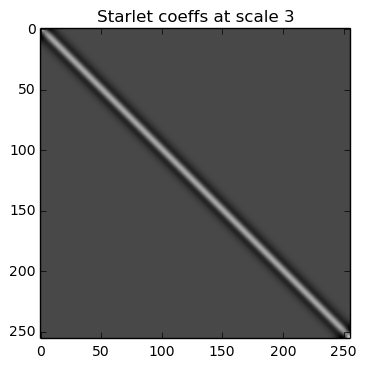

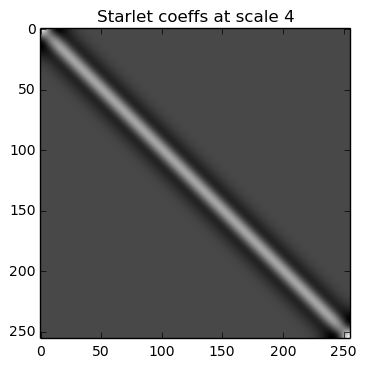

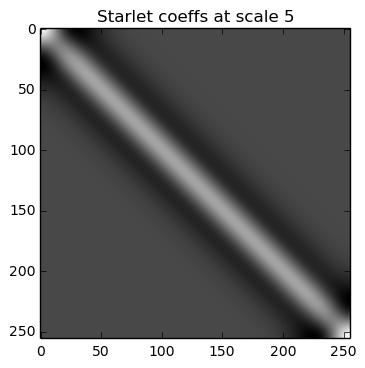

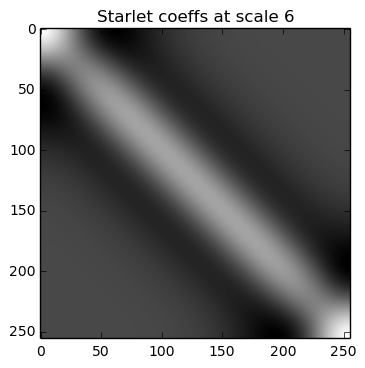

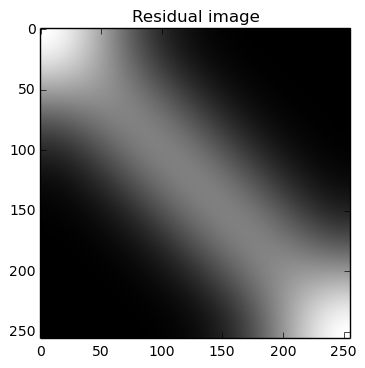

In [11]:
steps = 6
kronTransfoCoeffs, kronLastIm, kronMeanWav = starletTransform(kronIm, h1d, steps, cmap='gray')
plt.imshow(kronLastIm, cmap='gray')
plt.title('Residual image')
plt.show()

means of wavelet coefficients at each scale : [ 0.  0.  0.  0.  0.  0.]


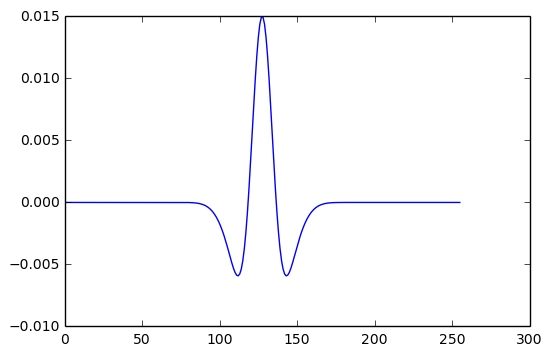

In [12]:
print('means of wavelet coefficients at each scale : {means}'.format(means=kronMeanWav))

scale = 4
diag_vals = np.zeros(256)
for i in range(256):
    diag_vals[i] = kronTransfoCoeffs[scale, i, 255 - i]
    
plt.plot(diag_vals)
plt.show()

This time again, the wavelet coefficients have a zero mean.
We can recognize a caracteristic wavelet on a slice that is perpendicular to the original signal.

## Reconstruction

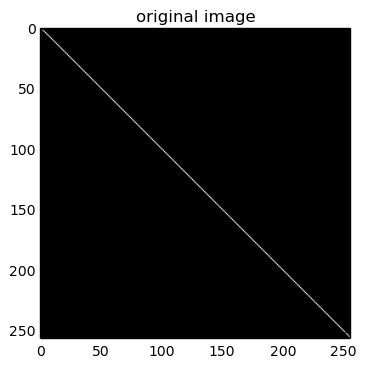

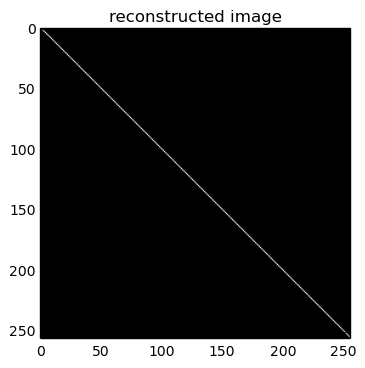

In [13]:
kronReconstructIm = reconstructImage(kronTransfoCoeffs, kronLastIm)

# Display original image
plt.imshow(kronReconstructIm, cmap='gray')
plt.title('original image')
plt.show()

# Display reconstructed image
plt.imshow(kronIm, cmap='gray')
plt.title('reconstructed image')
plt.show()

In [14]:
# Compute the pixel differences between the original and reconstructed images
print('Sum of pixel differences : {sum}'. format(sum=np.sum(kronReconstructIm - kronIm)))

Sum of pixel differences : 0.0


This time also, the original image can be perfectly reconstructed from the transform coefficients.

# Pure noise


We will now analyze the wavelet transform of a pure noise signal.

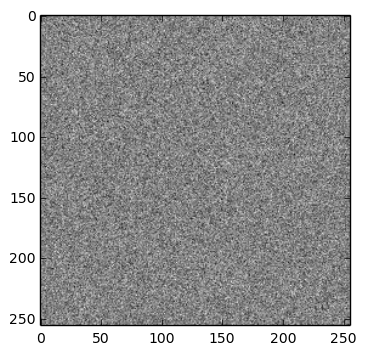

In [15]:
noise_level = 1
noiseIm = np.random.normal(0, noise_level, [256, 256])
plt.imshow(noiseIm, cmap='gray')
plt.show()

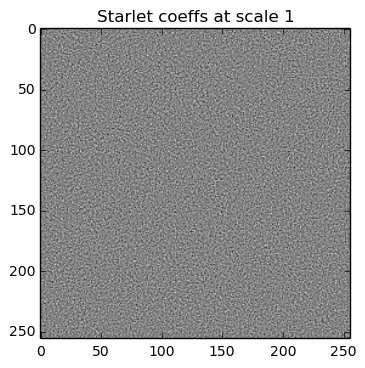

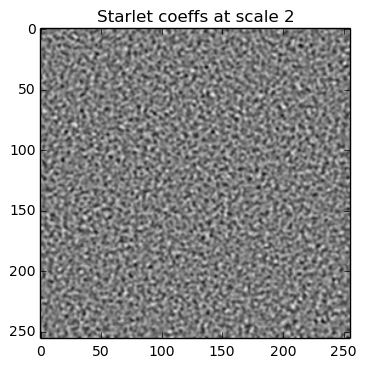

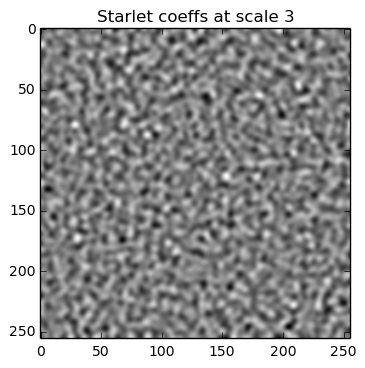

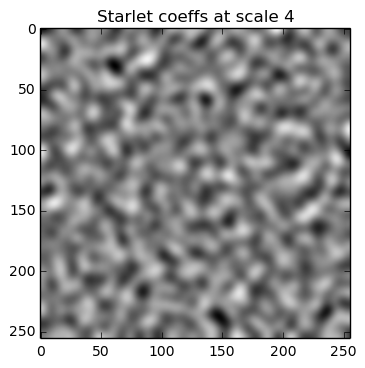

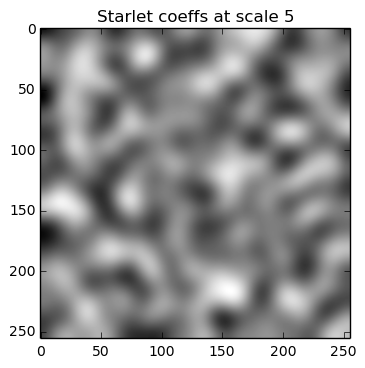

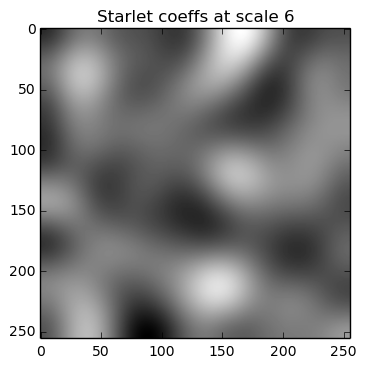

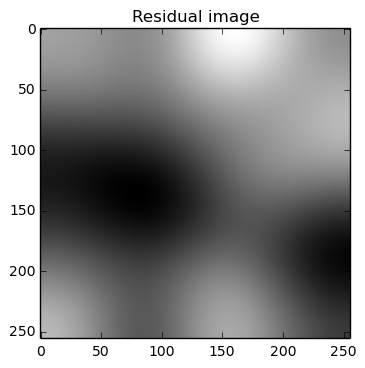

In [17]:
steps = 6
noiseTransfoCoeffs, noiseLastIm, NoiseMeanWav = starletTransform(noiseIm, h1d, steps, cmap='gray')
plt.imshow(noiseLastIm, cmap='gray')
plt.title('Residual image')
plt.show()

In [ ]:
stdVals = np.zeros(steps)
for idx in range(steps):
    stdVals[idx] = np.std(noiseTransfoCoeffs[idx, :, :])
    
plt.plot(stdVals)
plt.xlabel('wavelet scale')
plt.ylabel('standard deviation')
plt.show()

We observe that as the wavelet scale increases, the standard deviation of the coefficients decreases from the input noise level and converges towards a zero standard deviation.

# Automatically determine the scale of each noise level

To automatically determine the scale of each noise level, we can use the knowledge of the white noise contribution at each scale. To estimate the std of noise at each scale we compute the noise level of the original image, and multiply it by the pure noise std at each scale.
